In [14]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.stats as ss
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
# Import custom libraries
import generate_raw_hic_contacts_inter as phc

In [21]:
# Reload modules in case of modifications
reload(phc)

<module 'generate_raw_hic_contacts_inter' from '/home/louiscam/projects/gpcr/code/hic_preprocessing/generate_raw_hic_contacts_inter.py'>

In [16]:
# Specify directories and relevant information
genome_dir = '../../data/genome_data/'
raw_hic_dir = '../../data/hic/'
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'
chr1 = 10
chr2 = 11

### Load data

In [17]:
# Load raw HiC data
raw_hic_data = phc.get_raw_hic_sparse(raw_hic_dir, cell_type, resol_str, resol, quality, chr1, chr2)
raw_hic_data.head()

,locus_chr1,locus_chr2,value,norm_locus_chr1,norm_locus_chr2
0,0,0,15.0,1,1
1,1,0,7.0,1,1
2,2,0,5.0,1,1
3,3,0,2.0,1,1
4,4,0,2.0,1,1


In [18]:
# Normalize HiC data
normalized_hic_data = phc.normalize_raw_hic_sparse(raw_hic_data)
normalized_hic_data.head()

,locus_chr1,locus_chr2,value,norm_locus_chr1,norm_locus_chr2,norm_value
0,0,0,15.0,1,1,15.0
1,1,0,7.0,1,1,7.0
2,2,0,5.0,1,1,5.0
3,3,0,2.0,1,1,2.0
4,4,0,2.0,1,1,2.0


In [19]:
# Get chromosome sizes
df_sizes = phc.get_chrom_sizes(genome_dir,resol)
chr1_size = int(df_sizes[df_sizes['chr']==str(chr1)]['size_loci'])
chr2_size = int(df_sizes[df_sizes['chr']==str(chr2)]['size_loci'])
df_sizes.head(11)

,chr,size,size_loci,size_roundup
0,1,249250621,998,249500000
1,2,243199373,973,243250000
2,3,198022430,793,198250000
3,4,191154276,765,191250000
4,5,180915260,724,181000000
5,6,171115067,685,171250000
6,7,159138663,637,159250000
7,X,155270560,622,155500000
8,8,146364022,586,146500000
9,9,141213431,565,141250000


In [20]:
# Get dense HiC dataframe
df = phc.get_dense_hic_dataframe(normalized_hic_data, chr1_size, chr2_size, resol)
df.head()

,0,250000,500000,750000,1000000,1250000,1500000,1750000,2000000,2250000,...,132750000,133000000,133250000,133500000,133750000,134000000,134250000,134500000,134750000,135000000
0,15.0,7.0,7.0,4.0,2.0,7.0,3.0,3.0,5.0,0.0,...,3.0,0.0,0.0,2.0,3.0,2.0,1.0,2.0,2.0,0.0
250000,7.0,12.0,9.0,8.0,5.0,1.0,3.0,6.0,3.0,4.0,...,1.0,0.0,1.0,2.0,2.0,5.0,3.0,4.0,0.0,0.0
500000,5.0,14.0,4.0,10.0,6.0,4.0,5.0,5.0,4.0,6.0,...,0.0,0.0,0.0,1.0,5.0,1.0,0.0,2.0,2.0,0.0
750000,2.0,7.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,6.0,...,2.0,0.0,0.0,0.0,2.0,5.0,4.0,0.0,2.0,0.0
1000000,2.0,4.0,2.0,4.0,3.0,3.0,3.0,3.0,5.0,2.0,...,2.0,3.0,0.0,2.0,5.0,6.0,1.0,5.0,1.0,0.0


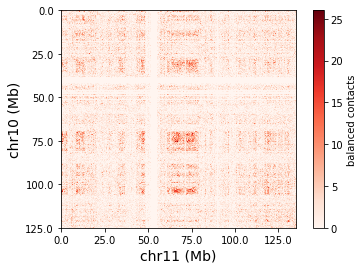

In [23]:
# Plot HiC dense dataframe
%matplotlib inline
plotname = 'norm_hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'.eps'
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df, chr1, chr2, plotname, hic_plots_dir)

### Filter out centromeres

In [24]:
# Get centromere locations
df_centrom = phc.get_centromere_locations(genome_dir)
df_centrom.head()

,bin,chrom,chromStart,chromEnd,ix,n,size,type,bridge
0,23,chr1,121535434,124535434,1270,N,3000000,centromere,no
1,20,chr2,92326171,95326171,770,N,3000000,centromere,no
2,2,chr3,90504854,93504854,784,N,3000000,centromere,no
3,1,chr4,49660117,52660117,447,N,3000000,centromere,no
4,14,chr5,46405641,49405641,452,N,3000000,centromere,no


In [25]:
# Filter out centromeres
filter_size = 2000000
df = phc.filter_centromeres(df, chr1, 'row', df_centrom, filter_size, resol)
df = phc.filter_centromeres(df, chr2, 'col', df_centrom, filter_size, resol)

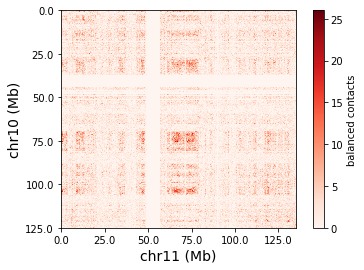

In [26]:
# Plot HiC data after filtering out centromeres
%matplotlib inline
plotname = 'norm_filtcentromeres_hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'.eps'
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df, chr1, chr2, plotname, hic_plots_dir)

### Filter out repeats

In [27]:
# Load repeats data
df_repeats = phc.load_repeats_data(genome_dir)
df_repeats.head()

,genoname,genoStart,genoEnd,repLength
0,chr1,10000,10468,468
1,chr1,10468,11447,979
2,chr1,11503,11675,172
3,chr1,11677,11780,103
4,chr1,15264,15355,91


In [28]:
# Find repeat-covered loci to filter out
chr_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
dic_repeats_tofilter = phc.find_repeat_locations(df_repeats, chr_list, df_sizes, resol)

In [29]:
dic_repeats_tofilter

{'1': array([ 20250000,  28500000,  28750000,  31500000,  32750000,  35500000,
         41500000,  45500000,  45750000,  46250000,  47250000,  48750000,
         49500000,  49750000,  50000000,  50250000,  51250000,  51500000,
         52500000,  53000000,  53250000,  55250000,  69000000,  69750000,
         71000000,  73500000,  75250000,  89500000,  89750000,  91500000,
         93750000, 102500000, 102750000, 105000000, 105750000, 106250000,
        108750000, 111250000, 111500000, 113250000, 119000000, 121250000,
        146750000, 155500000, 157250000, 159250000, 160750000, 164000000,
        171250000, 173250000, 173500000, 174000000, 176000000, 179250000,
        181750000, 191000000, 203750000, 211000000, 225000000, 225250000,
        244500000, 244750000, 248250000]),
 '2': array([ 22250000,  31750000,  35250000,  35750000,  47750000,  48250000,
         57250000,  61750000,  62000000,  63250000,  63500000,  73500000,
         73750000,  86750000,  88500000,  97000000,  985000

In [30]:
# Filter repeats for chr1 and chr2
df = phc.filter_repeats(df, chr1, dic_repeats_tofilter, 'row')
df = phc.filter_repeats(df, chr2, dic_repeats_tofilter, 'col')

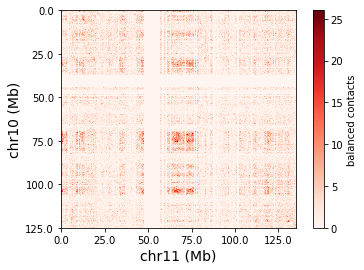

In [31]:
# Plot HiC data after filtering out centromeres
%matplotlib inline
plotname = 'norm_filtcentromeres_filtrepeats_hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'.eps'
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df, chr1, chr2, plotname, hic_plots_dir)

## Filter out outliers

In [50]:
# Filter out outliers
df_transformed = phc.filter_outliers(df)

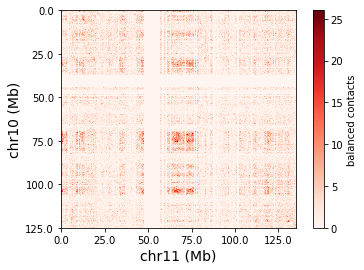

In [51]:
# Plot HiC data after filtering out centromeres, repeats and outliers
%matplotlib inline
plotname = 'norm_filtcentromeres_filtrepeats_filtoutliers_hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'.eps'
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df_transformed, chr1, chr2, plotname, hic_plots_dir)

In [19]:
df_transformed.head()

,0,250000,500000,750000,1000000,1250000,1500000,1750000,2000000,2250000,...,132750000,133000000,133250000,133500000,133750000,134000000,134250000,134500000,134750000,135000000
0,4.152706,2.856322,2.855208,2.281766,1.884402,2.974521,1.962390,2.022895,2.500478,0.000000,...,1.870582,0.000000,0.000000,1.678824,1.883130,1.499239,1.159687,1.598416,1.852900,0.0
250000,2.751617,2.715527,2.448582,2.285441,2.080270,0.846985,1.403814,2.026447,1.474823,1.562315,...,0.651856,0.000000,0.728183,1.159570,1.052790,1.680023,1.457886,1.601682,0.000000,0.0
500000,2.445225,2.865210,1.744627,2.492921,2.246325,1.849859,1.815672,1.874659,1.707964,1.899870,...,0.000000,0.000000,0.000000,0.742001,1.738541,0.630104,0.000000,1.095701,1.312275,0.0
750000,1.674105,2.252722,1.768006,1.716649,1.916454,1.873727,1.655203,1.482982,1.201050,1.923953,...,1.065055,0.000000,0.000000,0.000000,1.074789,1.707442,1.713078,0.000000,1.333005,0.0
1000000,1.697026,1.792380,1.252451,1.739787,1.699583,1.658679,1.450728,1.504801,1.942299,1.100260,...,1.083581,1.474233,0.000000,1.202347,1.785250,1.882878,0.774234,1.835299,0.890378,0.0
